In [1]:
import tf_silent
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from pinn import PINN
from network import Network
from optimizer import L_BFGS_B

In [2]:
def mass_cons(network, xy):
    """
    Compute u_x and v_y
    Args:
        xy: network input variables as ndarray.
    Returns:
        (u_x, v_y) as ndarray.
    """

    xy = tf.constant(xy)
    x, y = [ xy[..., i, tf.newaxis] for i in range(xy.shape[-1]) ]
    with tf.GradientTape(persistent=True) as g:
      g.watch(x)
      g.watch(y)

      u_v_p = network(tf.concat([x, y], axis=-1))
      u = u_v_p[..., 0, tf.newaxis]
      v = u_v_p[..., 1, tf.newaxis]
      p = u_v_p[..., 2, tf.newaxis]
    u_x = g.batch_jacobian(u, x)[..., 0]
    v_y = g.batch_jacobian(v, y)[..., 0]

    return u_x.numpy(), v_y.numpy()


In [3]:
def u_0(xy):
    """
    Initial wave form.
    Args:
        tx: variables (t, x) as tf.Tensor.
    Returns:
        u(t, x) as tf.Tensor.
    """

    x = xy[..., 0, None]
    y = xy[..., 1, None]


    return    4*y*(1 - y) 


In [4]:
def contour(x, y, z, title, levels=100):
    """
    Contour plot.
    Args:
        grid: plot position.
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """

    # get the value range
    vmin = np.min(z)
    vmax = np.max(z)
    # plot a contour
    font1 = {'family':'serif','size':20}
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    plt.axes()
    circle = plt.Circle((0.5,0.5),0.1, fc='black')
    plt.gca().add_patch(circle)
    plt.axis('scaled')
    plt.title(title, fontdict = font1)
    plt.xlabel("x", fontdict = font1)
    plt.ylabel("y", fontdict = font1)
    plt.tick_params(axis='both', which='major', labelsize=15)

    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)



In [5]:

"""
Test the physics informed neural network (PINN) model
for the cavity flow governed by the steady Navier-Stokes equation.
"""

# number of training samples
num_train_samples = 4000
# number of test samples
num_test_samples = 400

# inlet flow velocity
u0 = 1
# density
rho = 1
# viscosity
mu = 1e-1
# Re = (L*u0*rho)/mu ==> rho/mu = 10

# build a core network model
network = Network().build()
network.summary()
# build a PINN model
pinn = PINN(network, rho=rho, mu=mu).build()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 48)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_3 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 147       
Total params: 7,347
Trainable params: 7,347
Non-trainable params: 0
___________________________________________________________

In [6]:
# Domain and circle data
x_f =2
x_ini=0
y_f=1
y_ini=0
Cx = 0.5
Cy = 0.5
a = 0.1
b = 0.1

xyt_circle = np.random.rand(num_train_samples, 2)
xyt_circle[...,0] = 2*(a)*xyt_circle[...,0] +(Cx-a)
xyt_circle[0:num_train_samples//2,1] = b*(1 - (xyt_circle[0:num_train_samples//2,0]-Cx)**2 / a**2)**0.5 + Cy
xyt_circle[num_train_samples//2:,1] = -b*(1 - (xyt_circle[num_train_samples//2:,0]-Cx)**2 / a**2)**0.5 + Cy

# Interior domain sampling
xyt_eqn = np.random.rand(num_train_samples, 2)
xyt_eqn[...,0] = (x_f - x_ini)*xyt_eqn[...,0] + x_ini
xyt_eqn[...,1] = (y_f - y_ini)*xyt_eqn[...,1] + y_ini

# remove points inside the circle
for i in range(num_train_samples):
  while (xyt_eqn[i, 0] - Cx)**2/a**2 + (xyt_eqn[i, 1] - Cy)**2/b**2 < 1:
    xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand(1, 1) + x_ini
    xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand(1, 1) + y_ini

# Sample in the annulus (r+0.2) region # annulus is a plane region between two concentric circles
num_annulus_samples = 1500
theta = np.random.uniform(0, 2*np.pi, num_annulus_samples)
r = np.sqrt(np.random.uniform(1, 9, num_annulus_samples))  # sqrt for uniform area
# circle eqn in polar coordinates: x = Cx + a * r * cos(theta), y = Cy + b * r * sin(theta)
x = Cx + a * r * np.cos(theta)
y = Cy + b * r * np.sin(theta)
xyt_annulus = np.stack([x, y], axis=1)

# Wake region
num_strip_samples = 2500
x_strip = np.random.uniform(0.6, 1.2, num_strip_samples)
y_strip = np.random.uniform(0.3, 0.7, num_strip_samples)
xyt_strip = np.stack([x_strip, y_strip], axis=1)

xyt_roi_combined = np.concatenate([xyt_eqn, xyt_annulus, xyt_strip], axis=0)
num_interior_samples = xyt_roi_combined.shape[0]

xyt_w1 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w1[..., 0] = (x_f - x_ini)*xyt_w1[...,0] + x_ini
xyt_w1[..., 1] =  y_ini          # y-position is 0 or 1
num_w1_samples = xyt_w1.shape[0]

xyt_w2 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w2[..., 0] = (x_f - x_ini)*xyt_w2[...,0] + x_ini
xyt_w2[..., 1] =  y_f
num_w2_samples = xyt_w2.shape[0]

xyt_out = np.random.rand(num_train_samples-2000, 2)  # left-right boundaries
xyt_out[..., 0] = x_f
num_out_samples = xyt_out.shape[0]

xyt_in = np.random.rand(num_train_samples, 2)
xyt_in[..., 0] = x_ini
num_in_samples = xyt_in.shape[0]

# Aggregate input data for training
x_train = [
    xyt_roi_combined,  # All interior points (PDE loss)
    xyt_w1,            # Wall y=0
    xyt_w2,            # Wall y=1
    xyt_out,           # Outlet x=2
    xyt_in,            # Inlet x=0
    xyt_circle         # Cylinder boundary
]
# y_train: create outputs with respect to data shapes for each region
zeros_interior = np.zeros((xyt_roi_combined.shape[0], 3))
zeros_w1 = np.zeros((xyt_w1.shape[0], 3))
zeros_w2 = np.zeros((xyt_w2.shape[0], 3))
zeros_out = np.zeros((xyt_out.shape[0], 3))
zeros_circ = np.zeros((xyt_circle.shape[0], 3))

# Inlet boundary condition (update shape)
a = u_0(tf.constant(xyt_in)).numpy()
b = np.zeros((xyt_in.shape[0], 1))
onze = np.random.permutation(np.concatenate([a, b, a], axis=-1))

y_train = [
    zeros_interior,  # All interior points (PDE loss)
    zeros_w1,        # Wall y=0
    zeros_w2,        # Wall y=1
    zeros_out,       # Outlet x=2
    onze,            # Inlet x=0
    zeros_circ       # Cylinder boundary
]

In [15]:
print("Training data shapes:")
print("Labels of x: (x_cord, y_cord), y: (u, v, p)")
for x, y in zip(x_train, y_train):
    print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Training data shapes:
Labels of x: (x_cord, y_cord), y: (u, v, p)
Shape of x: (8000, 2), Shape of y: (8000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (2000, 2), Shape of y: (2000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)


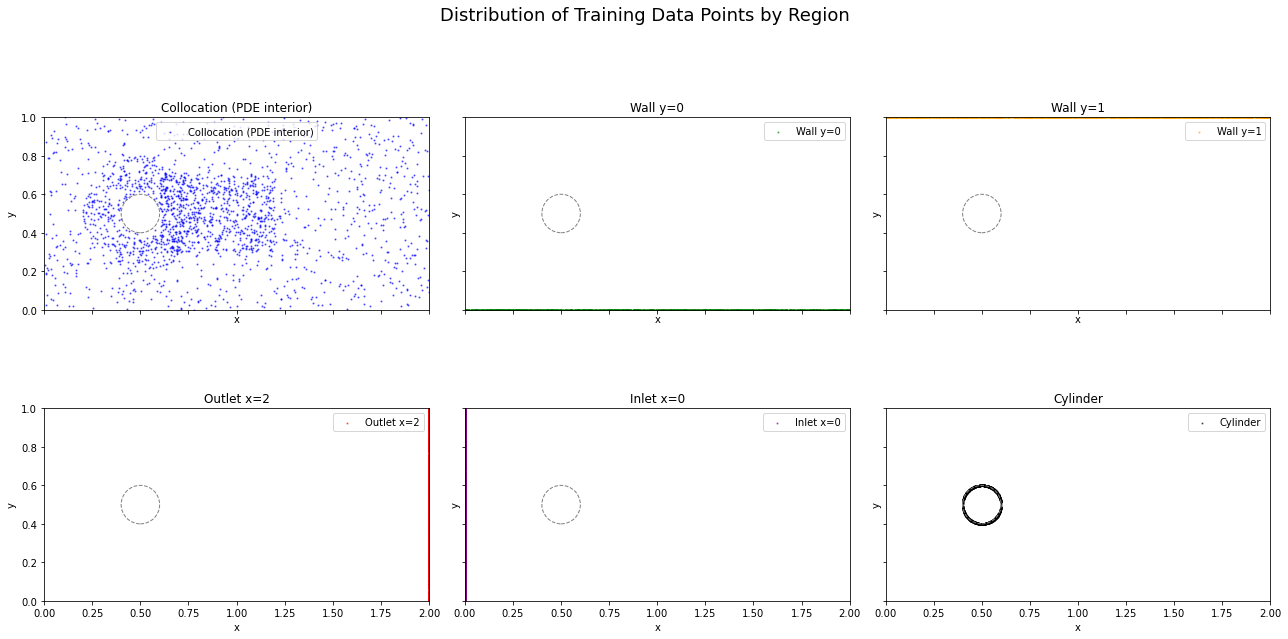

In [7]:
# --- Plot training data distribution ---
import matplotlib.pyplot as plt

# Subsample for clarity if too many points
def subsample(arr, max_points=2000):
    if arr.shape[0] > max_points:
        idx = np.random.choice(arr.shape[0], max_points, replace=False)
        return arr[idx]
    return arr

# Prepare data for plotting
data_labels = [
    ("Collocation (PDE interior)", xyt_roi_combined),
    ("Wall y=0", xyt_w1),
    ("Wall y=1", xyt_w2),
    ("Outlet x=2", xyt_out),
    ("Inlet x=0", xyt_in),
    ("Cylinder", xyt_circle)
]
colors = ['blue', 'green', 'orange', 'red', 'purple', 'black']
markers = ['.', '.', '.', '.', '.', '.']

fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axs = axs.flatten()
for i, (label, data) in enumerate(data_labels):
    arr = subsample(data)
    axs[i].scatter(arr[:, 0], arr[:, 1], s=5, c=colors[i], alpha=0.5, marker=markers[i], label=label)
    axs[i].set_title(label)
    axs[i].set_xlim([0, 2])
    axs[i].set_ylim([0, 1])
    axs[i].set_aspect('equal')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].legend(loc='best', fontsize=10)
    # Draw cylinder for reference
    circle = plt.Circle((0.5, 0.5), 0.1, color='gray', fill=False, linestyle='--')
    axs[i].add_patch(circle)
plt.suptitle("Distribution of Training Data Points by Region", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

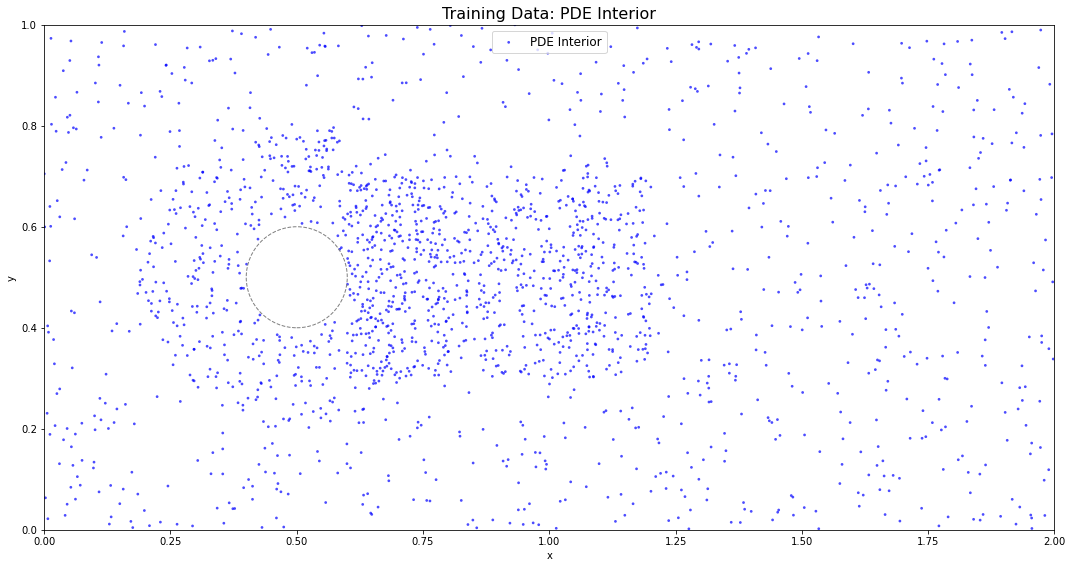

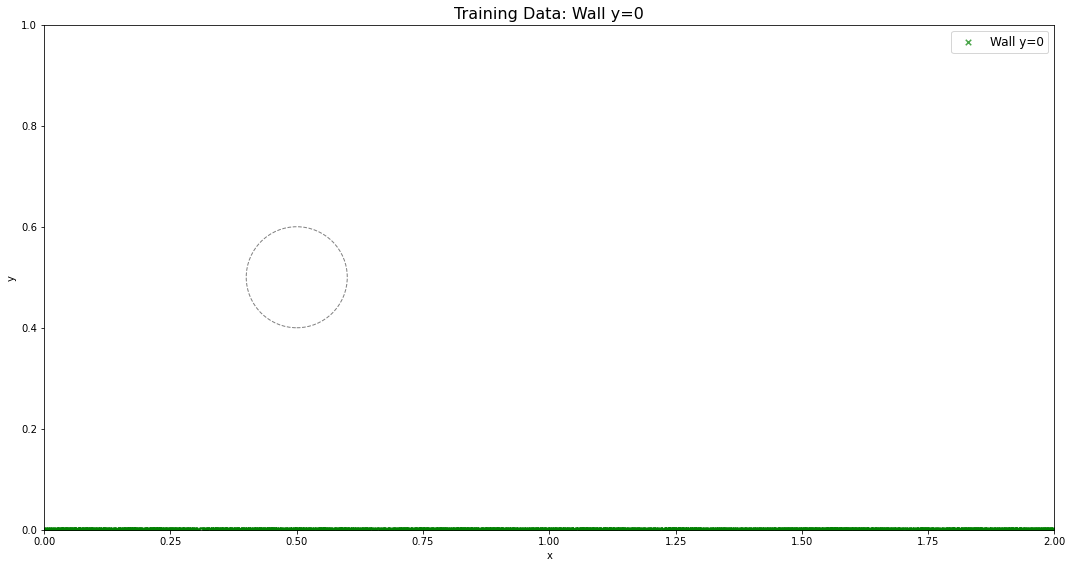

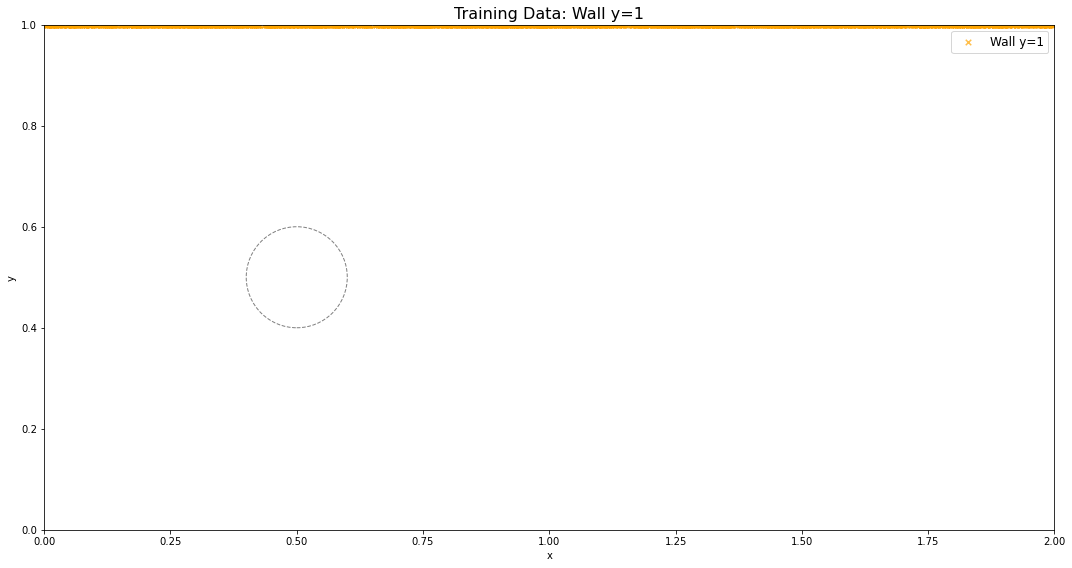

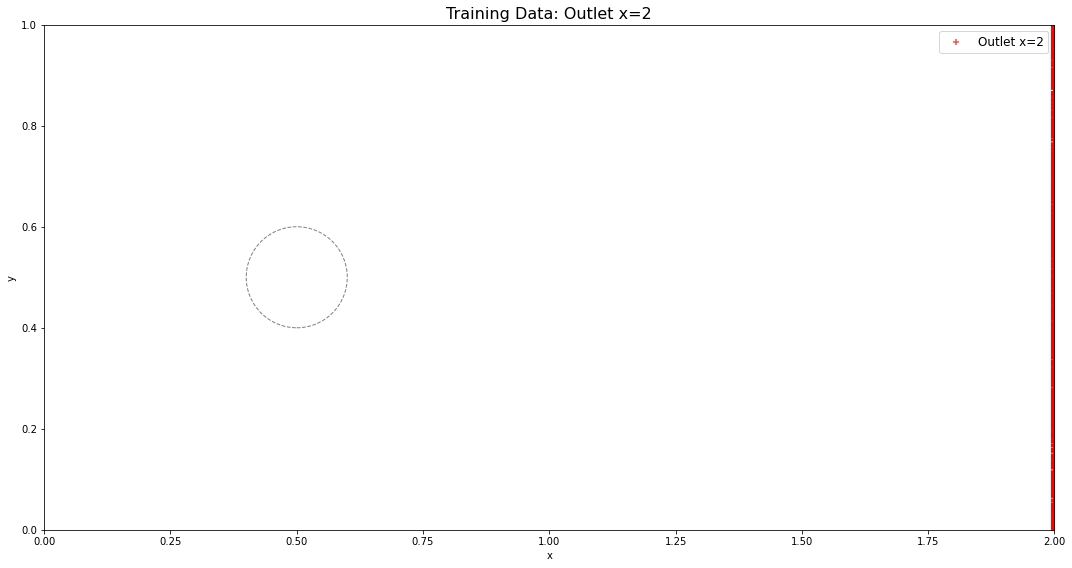

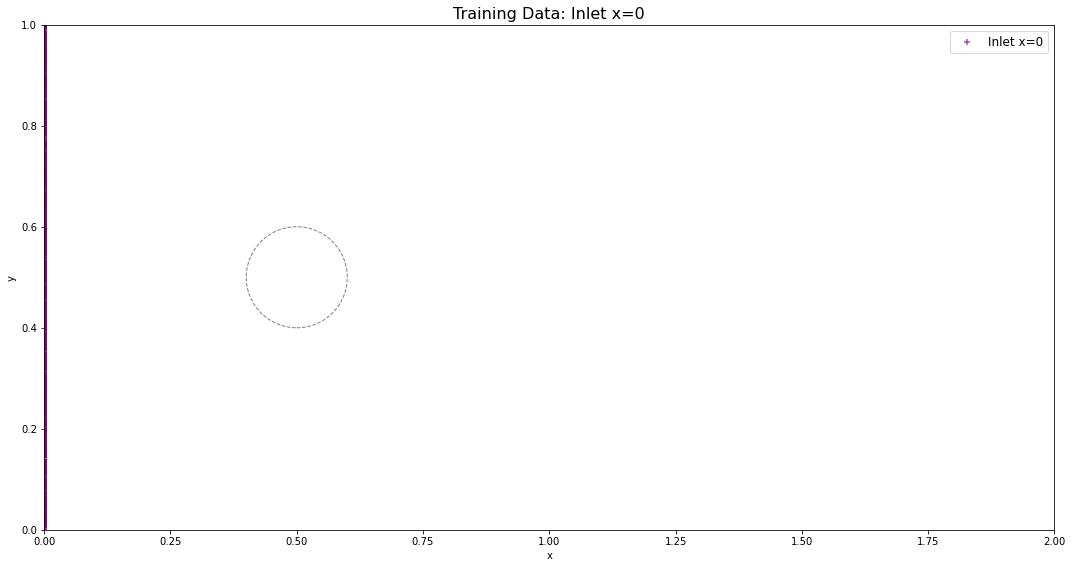

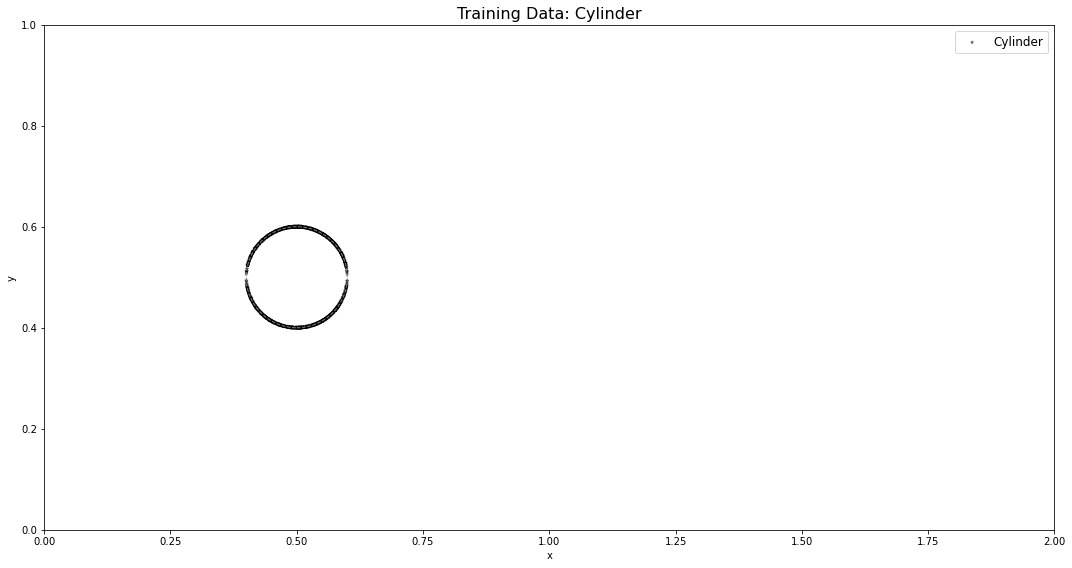

In [11]:
# --- Plot training data distribution (separate plots, distinct markers) ---
import matplotlib.pyplot as plt

def subsample(arr, max_points=2000):
    if arr.shape[0] > max_points:
        idx = np.random.choice(arr.shape[0], max_points, replace=False)
        return arr[idx]
    return arr

data_labels = [
    ("PDE Interior", xyt_roi_combined, 'blue', '.', 30),
    ("Wall y=0", xyt_w1, 'green', 'x', 30),
    ("Wall y=1", xyt_w2, 'orange', 'x', 30),
    ("Outlet x=2", xyt_out, 'red', '+', 30),
    ("Inlet x=0", xyt_in, 'purple', '+', 30),
    ("Cylinder", xyt_circle, 'black', '*', 20)
]

for label, data, color, marker, size in data_labels:
    arr = subsample(data)
    plt.figure(figsize=(15, 10))
    plt.scatter(arr[:, 0], arr[:, 1], s=size, c=color, alpha=0.7, marker=marker, label=label, edgecolors='none')
    plt.title(f"Training Data: {label}", fontsize=16)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([0, 2])
    plt.ylim([0, 1])
    plt.gca().set_aspect('equal')
    plt.legend(loc='best', fontsize=12)
    # Draw cylinder for reference
    circle = plt.Circle((0.5, 0.5), 0.1, color='gray', fill=False, linestyle='--')
    plt.gca().add_patch(circle)
    plt.tight_layout()
    plt.show()

In [ ]:
# num_roi_samples = 1000

# # Create more samples in the region of interest (ROI)
# rect_sample_space = np.random.rand(num_roi_samples*20, 2)
# rect_sample_space[..., 0] = (x_f - x_ini) * rect_sample_space[..., 0] + x_ini
# rect_sample_space[..., 1] = (y_f - y_ini) * rect_sample_space[..., 1] + y_ini

# # Circle parameters
# a=0.1
# b=0.1
# # Compute normalized squared distance from circle center
# r2 = ((rect_sample_space[:, 0] - Cx) ** 2) / a ** 2 + ((rect_sample_space[:, 1] - Cy) ** 2) / b ** 2

# # Mask for ROI: just outside the circle, up to r^2 = 5
# roi_mask = (r2 > 1) & (r2 < 4)

# xyt_roi = rect_sample_space[roi_mask][:num_roi_samples]

In [ ]:
# Sample in the annulus (r+0.2) region # annulus is a plane region between two concentric circles
num_roi_samples = 1500
theta = np.random.uniform(0, 2*np.pi, num_roi_samples)
r = np.sqrt(np.random.uniform(1, 9, num_roi_samples))  # sqrt for uniform area
# circle eqn in polar coordinates: x = Cx + a * r * cos(theta), y = Cy + b * r * sin(theta)
x = Cx + a * r * np.cos(theta)
y = Cy + b * r * np.sin(theta)
xyt_annulus = np.stack([x, y], axis=1)

# Sample in the rectangular wake region behind the cylinder area --> x:(0.6,1.2) y:(0.3,0.7)
num_strip_samples = 2500
x_strip = np.random.uniform(0.6, 1.2, num_strip_samples)
y_strip = np.random.uniform(0.3, 0.7, num_strip_samples)
xyt_strip = np.stack([x_strip, y_strip], axis=1)

# Combine all interior samples (eqn loss points) --> interioir + annulus + strip
xyt_roi_combined = np.concatenate([xyt_eqn, xyt_annulus, xyt_strip], axis=0)


In [78]:
len(xyt_roi_combined), len(xyt_eqn), len(xyt_annulus), len(xyt_strip)

(8000, 4000, 1500, 2500)

In [79]:
# Check for duplicate rows in xyt_roi_combined
unique_roi, idx_unique = np.unique(xyt_roi_combined, axis=0, return_index=True)
num_duplicates = len(xyt_roi_combined) - len(unique_roi)

print(f"Total points in combined ROI: {len(xyt_roi_combined)}")
print(f"Unique points in combined ROI: {len(unique_roi)}")
print(f"Number of duplicate points: {num_duplicates}")

Total points in combined ROI: 8000
Unique points in combined ROI: 8000
Number of duplicate points: 0


In [26]:

# create meshgrid coordinates (x, y) for test plots    

x = np.linspace(x_ini, x_f, num_test_samples)
y = np.linspace(y_ini, y_f, num_test_samples)
x, y = np.meshgrid(x, y)
xy = np.stack([x.flatten(), y.flatten()], axis=-1)
# predict (psi, p)
u_v_p = network.predict(xy, batch_size=len(xy))
u, v, p = [ u_v_p[..., i].reshape(x.shape) for i in range(u_v_p.shape[-1]) ]
# compute (u, v)
u = u.reshape(x.shape)
v = v.reshape(x.shape)
p = p.reshape(x.shape)


1/1 [==============================] - 0s 23ms/step
